In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

# 시계열 데이터 Shift 전/후 각 데이터 시각화

In [4]:
# Tensor 그래프를 초기화 시키는 함수(난수 seed 설정과 함께)
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [65]:
# initialize tensor graph
reset_graph()

# 시계열의 시작점과 끝점 정의
t_min, t_max = 0, 30
# 시계열 시간축에서 무작위로 샘플링할 간격 정의
resolution = 0.1

# 시계열 함수 생성
def time_series(t):
    return t*np.sin(t)/3 + 2*np.sin(t*5)

# 시계열 시간축에서 함수 인자로 정의한 횟수만큼 무작위로 데이터 샘플링하는 함수
def next_batch(batch_size, n_steps):
    '''
    batch_size: 계속적으로 샘플링하면서 하나의 샘플(시계열 데이터)의 길이
    n_steps: 몇 번을 샘플링할 것인지
    '''
    # 시작점 - rand로 0과 1사이의 균일 분포로부터 행이 batch_size, 열이 1개인(열 벡터) 2차원 데이터 생성
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps*resolution)
    # 20개의 행, 1개의 열로 이루어진 열벡터 t0에다가 21개가 들어있는 1차원 array를 더하면 broadcasting되면서 20개의 행, 21개의 열로 변환
    # 1개씩 shift시킬 것이기 때문에 21개로 만듦
    # 그리고 resolution(간격) 값을 곱해 
    Ts = t0 + np.arange(0, n_steps+1) * resolution
    # time_series함수에 21개(열)씩 들어있는 20개(행)의 데이터 샘플을 넣어서 시계열 데이터 20개를 생성
    ys = time_series(Ts)
    
    # RNN에 들어갈 입력값, 출력값을 3차원의 형태로 만들고(for RNN에 넣도록 열 벡터로 만들기 위해) return
    '''
    입력값 : 모든 데이터 샘플 각각의 0번째부터 20번째(:-1)까지만 추출
    출력값 : 모든 데이터 샘플 각각의 1번째부터 21번째(1:) 까지만 추출
    '''
    # 가장 바깥 축엔 1개의 요소, 중간 축엔 20개의 요소(데이터 샘플 개수) 가장 안쪽 축엔 20개의 요소(데이터 요소 개수=n_inputs)
    input_x = ys[:,:-1].reshape(-1, n_steps, 1)
    output_y = ys[:,1:].reshape(-1, n_steps, 1)
    return input_x, output_y

# np.linspace(start, stop, num) -> 시각화할 시간 축
'''
start : 배열의 시작값
stop : 배열의 끝값
num : 위 start ~ stop값까지 범위에서 *몇 개*로 일정한 간격을 갖는 array를 만들건지
'''
t = np.linspace(t_min, t_max, int((t_max-t_min)/resolution))

n_steps = 20
# Test 위한 시각화 그래프 시간축
t_instance = np.linspace(12.2, 12.2 + resolution*(n_steps+1), n_steps+1)

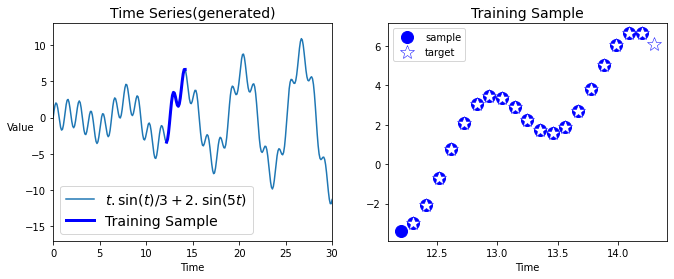

In [93]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("Time Series(generated)", fontsize=14)
# 전체 시계열 데이터
plt.plot(t, time_series(t), label=r"$t. \sin(t) / 3+2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), 'b-', linewidth=3, label='Training Sample')
plt.legend(loc='lower left', fontsize=14)
# plt.aixs[x축최소,x축최대,y축최소,y축최대]
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value", rotation=0)

# 다른 그래프 그리기
plt.subplot(122)
plt.title("Training Sample", fontsize=14)
# shift이전 시계열 데이터 시각화
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), 'bo', markersize=12, label='sample')
# shift이후 시계열 데이터 시각화(target으로 정의)
plt.plot(t_instance[1:], time_series(t_instance[1:]),
        'w*', markeredgewidth=0.5, markeredgecolor='b', markersize=14, label='target')
plt.legend(loc='upper left')
plt.xlabel("Time")
plt.show()

# RNN에 시계열 데이터 학습시키기

- stack하는 과정이 필요한 이유 : n_inputs도 1이고 n_outputs도 1인 것처럼 ``두 입/출력 사이즈가 동일``하도록 해줘야 하기 때문에. 이 과정이 주로 필요할 때는 중간 출력값들(y값들) 사이즈가 입력값들 사이즈와 동일해야만 할 때 즉, ``중간 출력값들이 무엇을 목적으로 계산되어질 필요가 있을 상황에 사용``된다

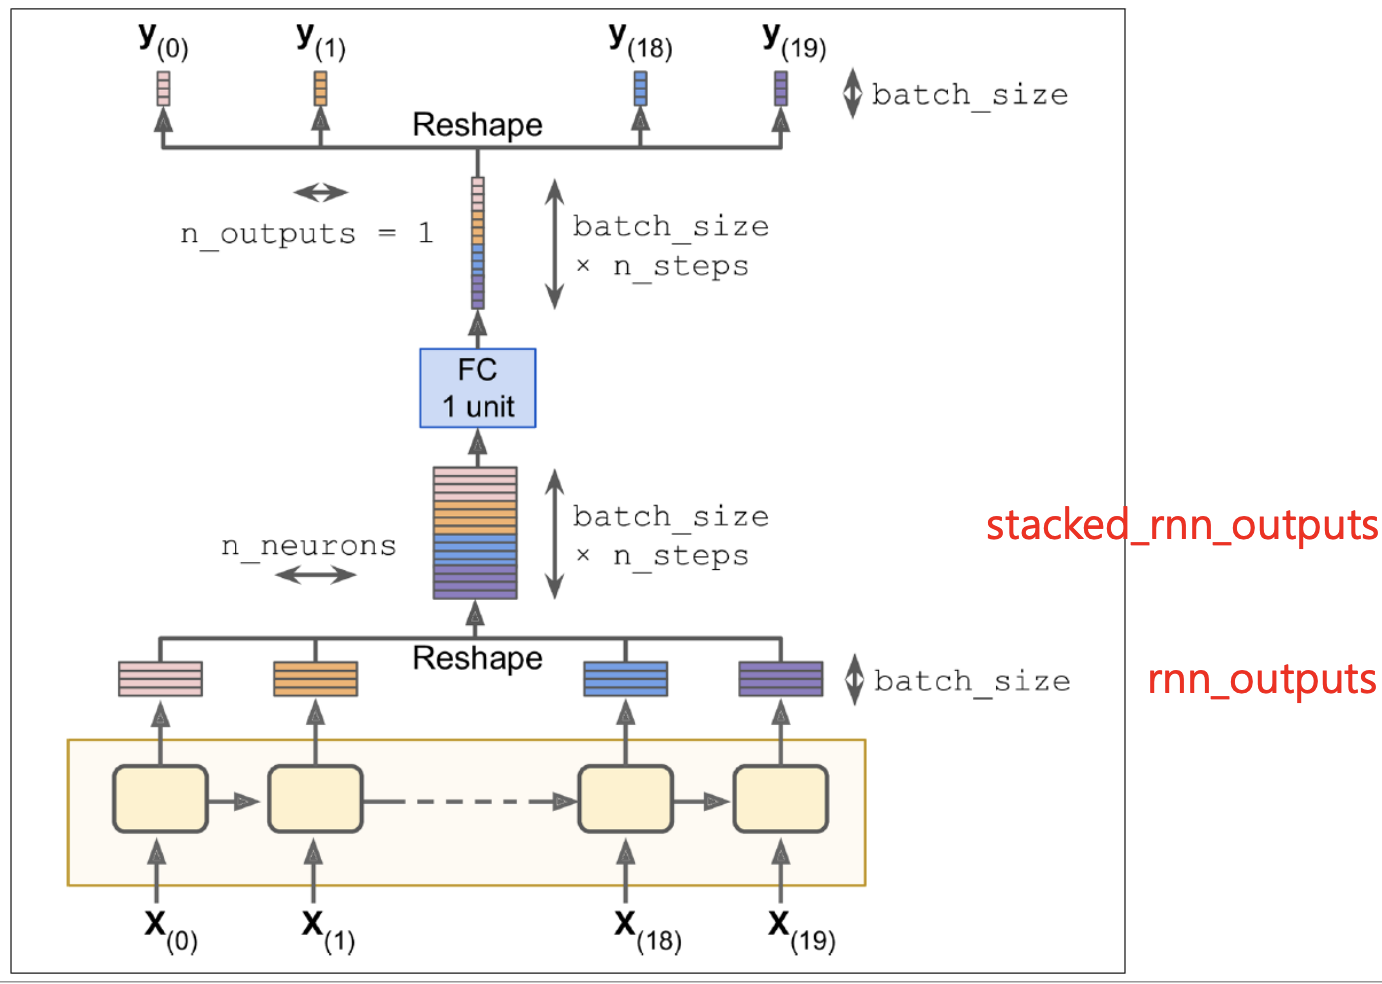

In [96]:
from IPython.display import Image
Image("/Users/younghun/Desktop/gitrepo/data/rnn_ts.png")

Step: 0, MSE: 13.9070
Step: 100, MSE: 0.5057
Step: 200, MSE: 0.2104
Step: 300, MSE: 0.1041
Step: 400, MSE: 0.0682
Step: 500, MSE: 0.0618

## Shape of y_pred:  (1, 20, 1)
## Value of y_pred:
 [[[-3.5451064]
  [-2.5237594]
  [-1.1689632]
  [ 0.546136 ]
  [ 2.0490522]
  [ 2.9901128]
  [ 3.498588 ]
  [ 3.5099547]
  [ 2.8451753]
  [ 2.1285563]
  [ 1.6292835]
  [ 1.5277606]
  [ 1.9074755]
  [ 2.6915088]
  [ 3.8608828]
  [ 5.125861 ]
  [ 6.1394496]
  [ 6.6800656]
  [ 6.6261263]
  [ 6.0294347]]]


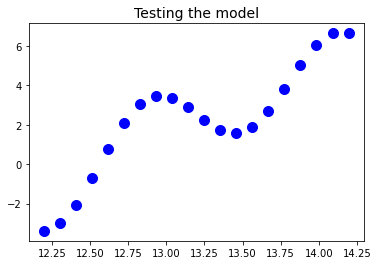

In [103]:
reset_graph()

# 파라미터 정의
n_steps = 20
n_neurons = 100
n_inputs = 1
n_outputs = 1

# shape=[샘플개수(batch_size), n_steps(시간축=RNN 개수), n_inputs]
X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])
Y = tf.placeholder(tf.float32, shape=[None, n_steps, n_outputs])

# 노드 개수가 100개이고 relu활성함수를 사용한 RNN Cell 만들기
cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
# 만든 RNN Cell을 연결해 각 RNN Cell에서 출력되는 n_neuron(RNN Cell안의 노드)개수 만큼의 결과값 출력(이 결과값이 그대로 중간출력값으로 가면 안됨!)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, inputs=X, dtype=tf.float32)

# 출력값 사이즈를 입력값 사이즈와 동일하도록 만들어주기 위해서 stack하기 위한 reshape
# 각 n_neurons 개수만큼 출력된 결과값들을 열(n_neurons)은 고정시키고 나머지(n_steps, batch_size)를 유동적으로 계산해 stack한 n_neurons개수만큼의 열 벡터가 도출
stacked_rnn_outputs = tf.reshape(tensor=rnn_outputs, shape=[-1, n_neurons])
# stack시킨 n_neurons개수의 열벡터를 FC layer에다가 집어넣어서 중간결과값 출력
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
# 이 때, 출력된 중간결과값들은 stack된 상태로 shape=[-1, n_outputs] 상태임 -> 이거를 원본 shape(batch_size, n_steps, n_outputs)로 unstack해주기
predictions = tf.reshape(tensor=stacked_outputs, shape=[-1, n_steps, n_outputs])

#### Train parameters
learning_rate = 0.001
n_iterations = 600
# 샘플 개수
batch_size = 50

# cost function 
mse = tf.losses.mean_squared_error(labels=Y, predictions=predictions)
# SGD
train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(mse)

#### Run Tensors ####
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for iteration in range(n_iterations):
        # 시계열 데이터 샘플링하고 파라미터 SGD 수행하면서 업데이트
        batch_x, batch_y = next_batch(batch_size, n_steps)
        sess.run(train, feed_dict={X: batch_x, Y: batch_y})
        if iteration % 100 == 0:
            cost = mse.eval(feed_dict={X: batch_x, Y: batch_y})
            print(f"Step: {iteration}, MSE: {cost :.4f}")
    ### SGD 수행 완료 후 최종적으로 업데이트된 파라미터를 가지고 Test 데이터(shift 1개 시킨 시계열 데이터)로 예측
    # shift시킨 시계열 데이터 생성
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(predictions, feed_dict={X: X_new})
print()
print("## Shape of y_pred: ", y_pred.shape)
print("## Value of y_pred:\n", y_pred)

#### 그래프로 예측값 vs 실제값 비교 ####
plt.title("Testing the model", fontsize=14)
# 학습 시계열 데이터
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), 'bo',
        markersize=10, label='instance')

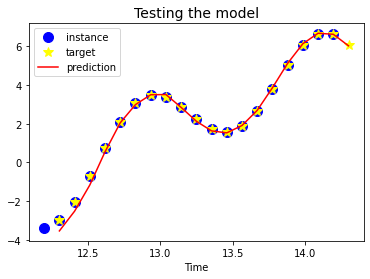

In [127]:
#### 그래프로 예측값 vs 실제값 비교 ####
plt.title("Testing the model", fontsize=14)
# 학습 시계열 데이터 - plot(x축, y축)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), 'bo',
        markersize=10, label='instance')
# shift 1개 시킨 정답 시계열 데이터
plt.plot(t_instance[1:], time_series(t_instance[1:]), 'w*',
        markersize=10, label='target', color='yellow')
# 예측 시계열 데이터 - y_pred를 1차원으로 표현하기 위해서 
plt.plot(t_instance[1:], y_pred[0, :, 0], 'r',
        markersize=10, label='prediction')
plt.legend(loc='upper left')
plt.xlabel("Time", fontsize=10)
plt.show()

In [124]:
# y_pred를 1차원으로 표현하는 실습
print(y_pred.shape,'\n',y_pred)
print()
print(y_pred[0].shape,'\n',y_pred[0])
print()
print(y_pred[0, :].shape,'\n', y_pred[0, :])
print()
print(y_pred[0, :, 0].shape,'\n', y_pred[0, :, 0])

(1, 20, 1) 
 [[[-3.5451064]
  [-2.5237594]
  [-1.1689632]
  [ 0.546136 ]
  [ 2.0490522]
  [ 2.9901128]
  [ 3.498588 ]
  [ 3.5099547]
  [ 2.8451753]
  [ 2.1285563]
  [ 1.6292835]
  [ 1.5277606]
  [ 1.9074755]
  [ 2.6915088]
  [ 3.8608828]
  [ 5.125861 ]
  [ 6.1394496]
  [ 6.6800656]
  [ 6.6261263]
  [ 6.0294347]]]

(20, 1) 
 [[-3.5451064]
 [-2.5237594]
 [-1.1689632]
 [ 0.546136 ]
 [ 2.0490522]
 [ 2.9901128]
 [ 3.498588 ]
 [ 3.5099547]
 [ 2.8451753]
 [ 2.1285563]
 [ 1.6292835]
 [ 1.5277606]
 [ 1.9074755]
 [ 2.6915088]
 [ 3.8608828]
 [ 5.125861 ]
 [ 6.1394496]
 [ 6.6800656]
 [ 6.6261263]
 [ 6.0294347]]

(20, 1) 
 [[-3.5451064]
 [-2.5237594]
 [-1.1689632]
 [ 0.546136 ]
 [ 2.0490522]
 [ 2.9901128]
 [ 3.498588 ]
 [ 3.5099547]
 [ 2.8451753]
 [ 2.1285563]
 [ 1.6292835]
 [ 1.5277606]
 [ 1.9074755]
 [ 2.6915088]
 [ 3.8608828]
 [ 5.125861 ]
 [ 6.1394496]
 [ 6.6800656]
 [ 6.6261263]
 [ 6.0294347]]

(20,) 
 [-3.5451064 -2.5237594 -1.1689632  0.546136   2.0490522  2.9901128
  3.498588   3.5099547  2

# OutputProjectionWrapper
- 위에와 달리 ``각각의 input의 RNN Cell을 거치고 나와서 각각에 FC layer를 해주는 방법``

In [130]:
reset_graph()

# 파라미터 정의
n_steps = 20
n_neurons = 100
n_inputs = 1
n_outputs = 1

X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])
Y = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])

# RNN Cell만들고 입력데이터 넣은다음 각 RNN Cell에서 나온 결과값에 각기 FC layer을 만들어줌
cell = tf.contrib.rnn.OutputProjectionWrapper(tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons,
                                                                         activation=tf.nn.relu),
                                             output_size=n_outputs)
# 위에서 만든 것들을 연결해서 결과값 출력
predictions, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

### Train parameters ###
learning_rate = 0.001
n_iterations = 600
# 샘플 개수
batch_size = 50

# cost function
mse = tf.losses.mean_squared_error(labels=Y, predictions=predictions)
# SGD
train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(mse)

### Run Tensors ###
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for iteration in range(n_iterations):
        batch_x, batch_y = next_batch(batch_size, n_steps)
        # SGD 수행해서 파라미터 업데이트
        sess.run(train, feed_dict={X: batch_x, Y: batch_y})
        if iteration % 100 == 0:
            cost = sess.run(mse, feed_dict={X: batch_x, Y: batch_y})
            print(f"Step: {iteration}, MSE: {cost :.4f}")
    # SGD 수행 완료 후 최종 파라미터로 업데이트 되어있음
    # 테스트 데이터로서 새로운 시계열 데이터 정의
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(predictions, feed_dict={X: X_new})
    
print()
print("## Shape of y_pred: ", y_pred.shape)
print("## Value of y_pred:\n", y_pred)

Step: 0, MSE: 11.9673
Step: 100, MSE: 0.5228
Step: 200, MSE: 0.1500
Step: 300, MSE: 0.0751
Step: 400, MSE: 0.0618
Step: 500, MSE: 0.0615

## Shape of y_pred:  (1, 20, 1)
## Value of y_pred:
 [[[-3.5262268]
  [-2.4672015]
  [-1.1419667]
  [ 0.5639766]
  [ 2.1380877]
  [ 3.181482 ]
  [ 3.4333177]
  [ 3.2610493]
  [ 2.8540754]
  [ 2.2927241]
  [ 1.7760007]
  [ 1.4578816]
  [ 1.7960271]
  [ 2.6859846]
  [ 3.8808458]
  [ 5.125532 ]
  [ 6.1072383]
  [ 6.6790466]
  [ 6.6470914]
  [ 6.0377955]]]


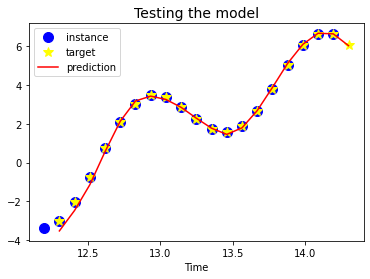

In [132]:
#### 그래프로 예측값 vs 실제값 비교 ####
plt.title("Testing the model", fontsize=14)
# 학습 시계열 데이터 - plot(x축, y축)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), 'bo',
        markersize=10, label='instance')
# shift 1개 시킨 정답 시계열 데이터
plt.plot(t_instance[1:], time_series(t_instance[1:]), 'w*',
        markersize=10, label='target', color='yellow')
# 예측 시계열 데이터 - y_pred를 1차원으로 표현하기 위해서 
plt.plot(t_instance[1:], y_pred[0, :, 0], 'r',
        markersize=10, label='prediction')
plt.legend(loc='upper left')
plt.xlabel("Time", fontsize=10)
plt.show()

In [ ]:
#### 진도나간 데까지 실습 다 해보고 shift 간격 바꾸어서 예측결과 살펴보기